In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (train_test_split, GridSearchCV, HalvingGridSearchCV, RepeatedStratifiedKFold)
from sklearn.tree import plot_tree
from sklearn import metrics
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.metrics import roc_curve


In [3]:
df = pd.read_csv("data/Customer Churn.csv", delimiter=",")

'''
Anonymous Customer ID

Call Failures: number of call failures

Complains: binary (0: No complaint, 1: complaint)

Subscription Length: total months of subscription

Charge Amount: Ordinal attribute (0: lowest amount, 9: highest amount)

Seconds of Use: total seconds of calls

Frequency of use: total number of calls

Frequency of SMS: total number of text messages

Distinct Called Numbers: total number of distinct phone calls 

Age Group: ordinal attribute (1: younger age, 5: older age)

Tariff Plan: binary (1: Pay as you go, 2: contractual)

Status: binary (1: active, 2: non-active)

Churn: binary (1: churn, 0: non-churn) - Class label

Customer Value: The calculated value of customer'''


'\nAnonymous Customer ID\n\nCall Failures: number of call failures\n\nComplains: binary (0: No complaint, 1: complaint)\n\nSubscription Length: total months of subscription\n\nCharge Amount: Ordinal attribute (0: lowest amount, 9: highest amount)\n\nSeconds of Use: total seconds of calls\n\nFrequency of use: total number of calls\n\nFrequency of SMS: total number of text messages\n\nDistinct Called Numbers: total number of distinct phone calls \n\nAge Group: ordinal attribute (1: younger age, 5: older age)\n\nTariff Plan: binary (1: Pay as you go, 2: contractual)\n\nStatus: binary (1: active, 2: non-active)\n\nChurn: binary (1: churn, 0: non-churn) - Class label\n\nCustomer Value: The calculated value of customer'

In [4]:
df.keys()

Index(['Call  Failure', 'Complains', 'Subscription  Length', 'Charge  Amount',
       'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status', 'Age',
       'Customer Value', 'Churn'],
      dtype='object')

In [5]:
predictor_keys = [x for x in df.keys() if not x =='Churn']
label_key = ['Churn']

In [33]:
RF_HP_params = dict(
    min_samples_leaf = [1, 2, 3, 4, 5],
    n_estimators = [50, 100, 250, 500, 1000, 2000],
    # max_depth = [None, 5, 10, 20, 35],
)

HGBC_HP_params = dict(
    min_samples_leaf = [10, 20, 30, 40, 50],
    learning_rate = [1e-2, 1e-1, 2.5e-1],
    l2_regularization = [0, 1e-2, 1e-1]
)

RF_model = RandomForestClassifier(class_weight = 'balanced_subsample')
HGBC_model = HistGradientBoostingClassifier(class_weight = 'balanced')

RF_grid_search = GridSearchCV(estimator = RF_model, param_grid= RF_HP_params, cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5), n_jobs =15, scoring = 'f1', verbose = 10)
HGBC_grid_search = GridSearchCV(estimator = HGBC_model, param_grid= HGBC_HP_params, cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 50), n_jobs=15, scoring = 'f1', verbose =10)


In [34]:
RF_grid_search.fit(df[predictor_keys], df[label_key].values.ravel())

Fitting 25 folds for each of 30 candidates, totalling 750 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=None),
             estimator=RandomForestClassifier(class_weight='balanced_subsample'),
             n_jobs=15,
             param_grid={'min_samples_leaf': [1, 2, 3, 4, 5],
                         'n_estimators': [50, 100, 250, 500, 1000, 2000]},
             scoring='f1', verbose=10)

In [10]:
doge = RF_grid_search.cv_results_

In [61]:
RF_grid_search.cv_results_

{'mean_fit_time': array([0.29102612, 0.5711507 , 1.33979694, 2.68638738, 5.5922087 ,
        0.26795077, 0.50292277, 1.25749691, 2.62869994, 5.52660545,
        0.2436347 , 0.52426394, 1.35034275, 2.68218986, 5.31282965,
        0.25079966, 0.51317541, 1.35383526, 2.69792978, 4.64839625,
        0.28139146, 0.5283788 , 1.23880498, 2.33317033, 3.62324762]),
 'std_fit_time': array([0.00702244, 0.00861707, 0.03061517, 0.02315223, 0.04342534,
        0.00235045, 0.00543795, 0.01875269, 0.05701229, 0.04759795,
        0.00308497, 0.01507634, 0.02132197, 0.03883989, 0.08684207,
        0.00508987, 0.01879981, 0.02677367, 0.07877171, 0.03409799,
        0.01232557, 0.02539032, 0.02471973, 0.02894633, 0.08630863]),
 'mean_score_time': array([0.01230009, 0.02393548, 0.04452403, 0.08587035, 0.17164548,
        0.01163522, 0.01832771, 0.04446967, 0.08723815, 0.17562207,
        0.00964061, 0.01812323, 0.04170012, 0.08563757, 0.1382854 ,
        0.01030644, 0.01832501, 0.04415973, 0.08257937, 0.12

<Axes: >

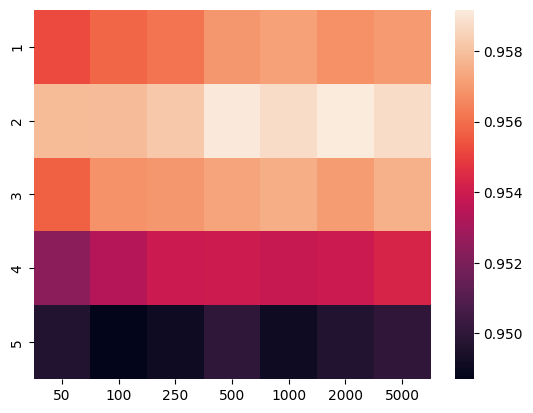

In [12]:
sns.heatmap(doge['mean_test_score'].reshape(5,7), xticklabels=RF_HP_params['n_estimators'], yticklabels=RF_HP_params['min_samples_leaf'])

In [64]:
model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)

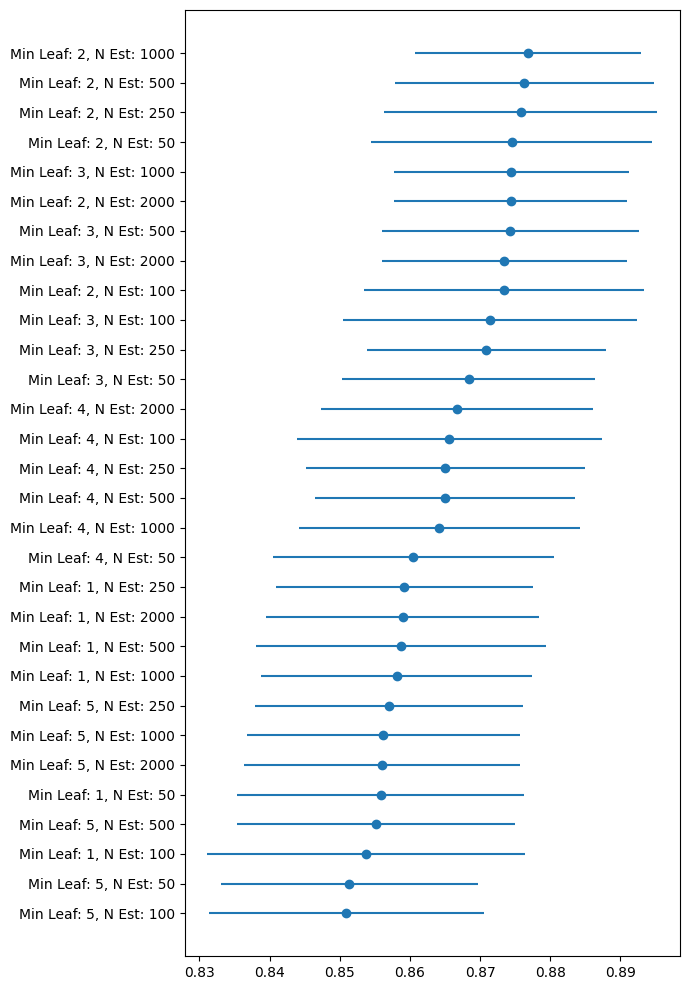

In [63]:
error_plotter = pd.DataFrame(RF_grid_search.cv_results_)
error_plotter['params'] = error_plotter['params'].apply(lambda x: f"Min Leaf: {x['min_samples_leaf']}, N Est: {x['n_estimators']}")
model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)

plt.subplots(figsize = (7,10))
plt.errorbar(error_plotter['mean_test_score'].values[model_perf_sort_inds], 
             range(len(error_plotter['params'])),
             xerr = error_plotter['std_test_score'].values[model_perf_sort_inds], fmt='o')

plt.yticks(range(len(error_plotter['params'])), error_plotter['params'].values[model_perf_sort_inds]);
plt.tight_layout()


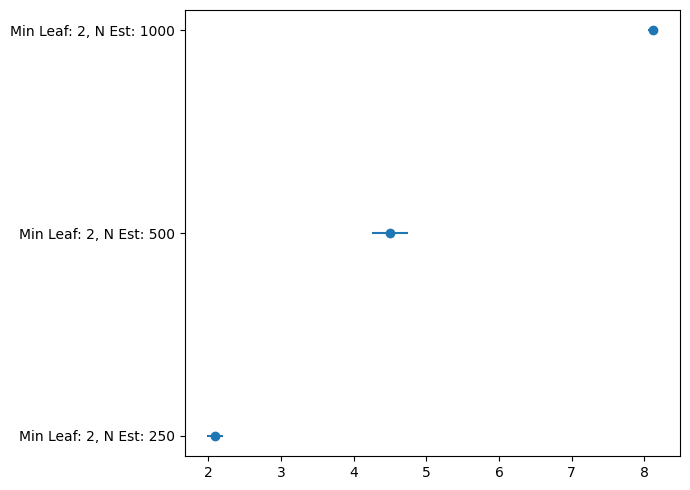

In [70]:
model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)[-3:]

plt.subplots(figsize = (7,5))
plt.errorbar(error_plotter['mean_fit_time'].values[model_perf_sort_inds], 
             range(len(model_perf_sort_inds)),
             xerr = error_plotter['std_fit_time'].values[model_perf_sort_inds], fmt='o')

plt.yticks(range(len(model_perf_sort_inds)), error_plotter['params'].values[model_perf_sort_inds]);
plt.tight_layout()

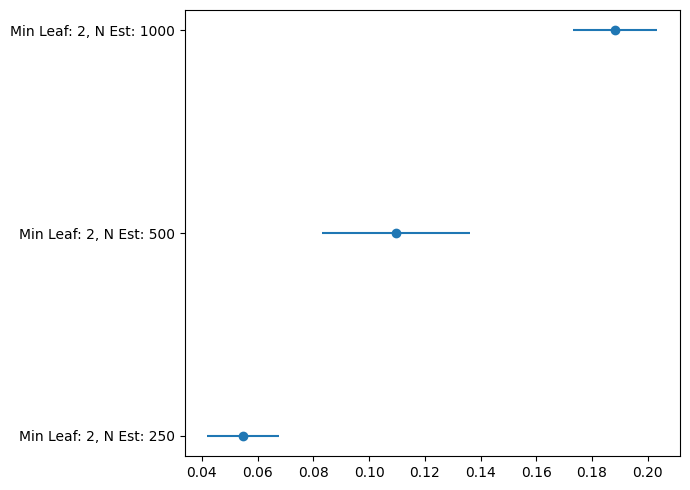

In [71]:
model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)[-3:]

plt.subplots(figsize = (7,5))
plt.errorbar(error_plotter['mean_score_time'].values[model_perf_sort_inds], 
             range(len(model_perf_sort_inds)),
             xerr = error_plotter['std_score_time'].values[model_perf_sort_inds], fmt='o')

plt.yticks(range(len(model_perf_sort_inds)), error_plotter['params'].values[model_perf_sort_inds]);
plt.tight_layout()

In [37]:
HGBC_grid_search.fit(df[predictor_keys], df[label_key].values.ravel())

Fitting 250 folds for each of 45 candidates, totalling 11250 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=50, n_splits=5, random_state=None),
             estimator=HistGradientBoostingClassifier(class_weight='balanced'),
             n_jobs=15,
             param_grid={'l2_regularization': [0, 0.01, 0.1],
                         'learning_rate': [0.01, 0.1, 0.25],
                         'min_samples_leaf': [10, 20, 30, 40, 50]},
             scoring='f1', verbose=10)

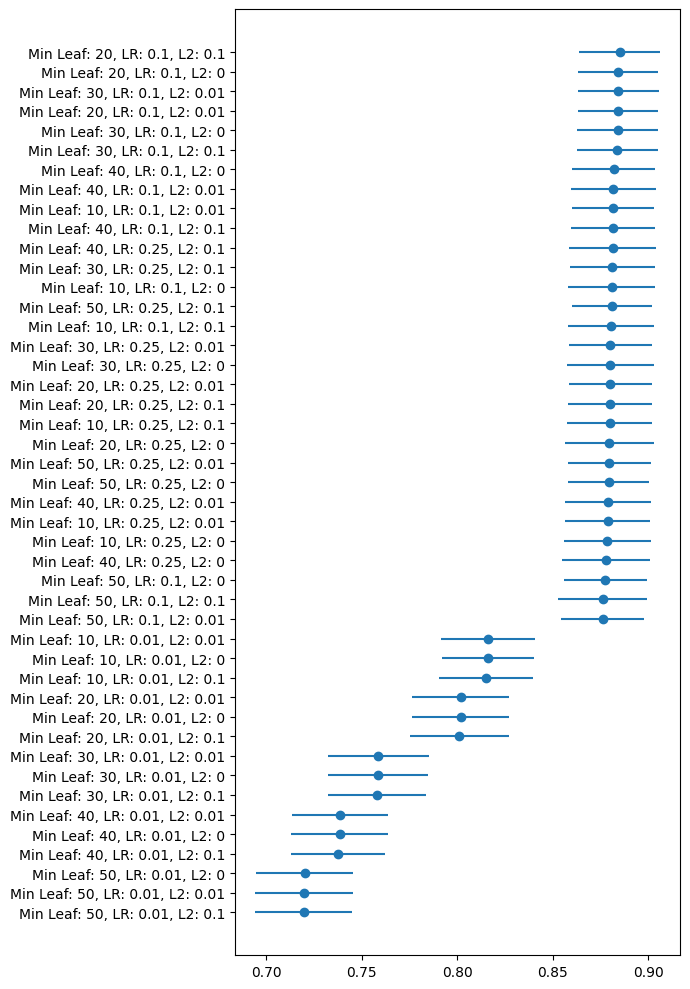

In [62]:
error_plotter = pd.DataFrame(HGBC_grid_search.cv_results_)
error_plotter['params'] = error_plotter['params'].apply(lambda x: f"Min Leaf: {x['min_samples_leaf']}, LR: {x['learning_rate']}, L2: {x['l2_regularization']}")

model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)

plt.subplots(figsize = (7,10))
plt.errorbar(error_plotter['mean_test_score'].values[model_perf_sort_inds], 
             range(len(error_plotter['params'])),
             xerr = error_plotter['std_test_score'].values[model_perf_sort_inds], fmt='o')

plt.yticks(range(len(error_plotter['params'])), error_plotter['params'].values[model_perf_sort_inds]);
plt.tight_layout()

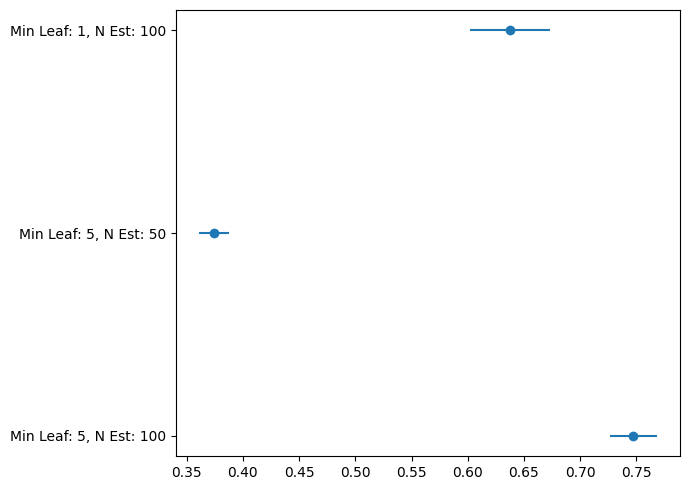

In [68]:
model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)[-3:]

plt.subplots(figsize = (7,5))
plt.errorbar(error_plotter['mean_fit_time'].values[model_perf_sort_inds], 
             range(len(model_perf_sort_inds)),
             xerr = error_plotter['std_fit_time'].values[model_perf_sort_inds], fmt='o')

plt.yticks(range(len(model_perf_sort_inds)), error_plotter['params'].values[model_perf_sort_inds]);
plt.tight_layout()

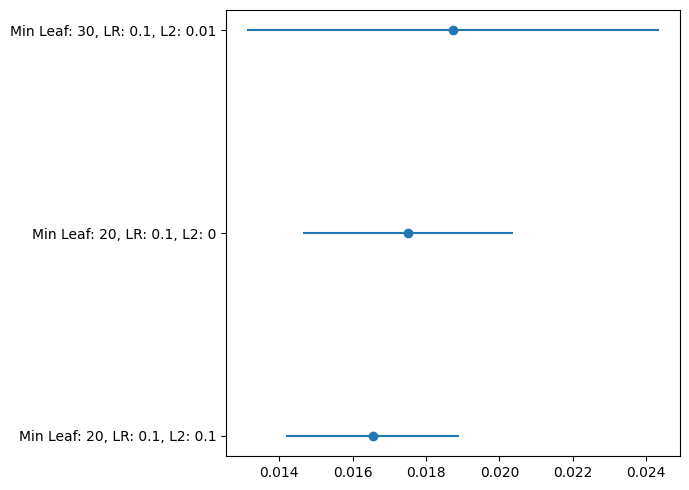

In [60]:
model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)[-3:]

plt.subplots(figsize = (7,5))
plt.errorbar(error_plotter['mean_score_time'].values[model_perf_sort_inds], 
             range(len(model_perf_sort_inds)),
             xerr = error_plotter['std_score_time'].values[model_perf_sort_inds], fmt='o')

plt.yticks(range(len(model_perf_sort_inds)), error_plotter['params'].values[model_perf_sort_inds]);
plt.tight_layout()

In [ ]:
RF_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

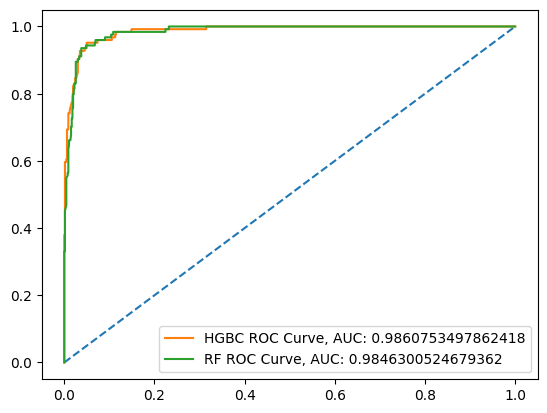

In [107]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(df[predictor_keys], df[label_key].values.ravel(), stratify=df[label_key].values.ravel())
best_RF_model = RF_grid_search.best_estimator_.fit(Xtrain, Ytrain)
best_HGBC_model = HGBC_grid_search.best_estimator_.fit(Xtrain, Ytrain)

plt.figure()
plt.plot(np.linspace(0,1), np.linspace(0,1), linestyle = 'dashed')
for model, name in zip([best_HGBC_model, best_RF_model],['HGBC', 'RF']):
    fpr, tpr, thresholds = roc_curve(Ytest, model.predict_proba(Xtest)[:,1])
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = f'{name} ROC Curve, AUC: {auc}')

plt.legend()
plt.show()

In [124]:
#let's move forward with the HGBC, first to make sure we get a nice stable threshold
ideal_thres_stack = []
for i in range(500):
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(df[predictor_keys], df[label_key].values.ravel(), test_size=0.3, stratify=df[label_key].values.ravel())
    best_HGBC_model.fit(Xtrain, Ytrain)
    fpr, tpr, thresholds = roc_curve(Ytest, best_HGBC_model.predict_proba(Xtest)[:,1])

    gmeans = np.sqrt(tpr*(1-fpr))
    ideal_thres_stack.append(np.argmax(gmeans))
ideal_thres = np.round(np.mean(ideal_thres_stack))

In [126]:
ideal_thres = np.round(np.mean(ideal_thres_stack))

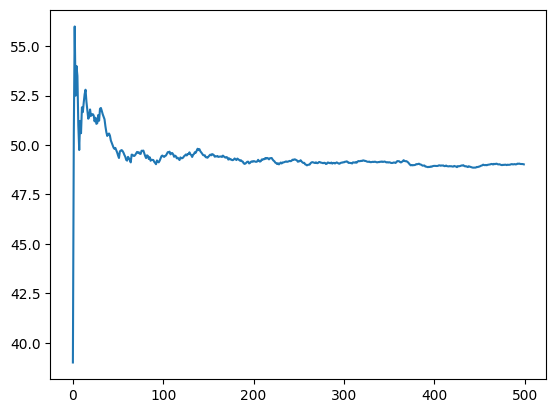

In [125]:
plt.plot(np.cumsum(ideal_thres_stack)/(np.arange(len(ideal_thres_stack))+1))

In [141]:
class reThresh_HGBC:
    def __init__(self, model, thresh = 0.5) -> None:
        self.model = model
        self.thresh = thresh
    def predict(self, X) -> int:
        return (self.model.predict_proba(X)[:,1]*100>=self.thresh).astype(int)
    def fit(self, X, Y) -> None:
        self.model = self.model.fit(X, Y)

In [144]:
final_model = reThresh_HGBC(best_HGBC_model, ideal_thres)
perform = {'Tuned HGBC': [], 'Untuned HGBC':[]}
for model, model_name in zip([final_model, best_HGBC_model], ['Tuned HGBC', 'Untuned HGBC']):
    for i in range(50):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(df[predictor_keys], df[label_key].values.ravel(), test_size=0.3, stratify=df[label_key].values.ravel())
        model.fit(Xtrain, Ytrain)
        perform[model_name].append(metrics.f1_score(Ytest, model.predict(Xtest)))


<Axes: >

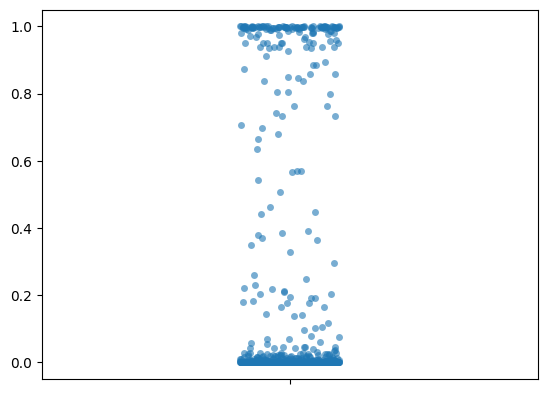

In [147]:
best_HGBC_model.fit(Xtrain, Ytrain)
proba = best_HGBC_model.predict_proba(Xtest)[:,1]
sns.stripplot(y=proba, alpha=0.6)

In [145]:
for model_name, f1s in perform.items():
    print(f'{model_name} has a mean f1 of {np.mean(f1s)} with a std of {np.std(f1s)}')

Tuned HGBC has a mean f1 of 0.8802682253442577 with a std of 0.02141362318810133
Untuned HGBC has a mean f1 of 0.8789359888253258 with a std of 0.017654579452064334
